# Visualizing a swing from c3d data

In [1]:
import ezc3d
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

rcParams['font.family'] = 'monospace'

The c3d file naming convention is detailed in the [baseball_hitting `README`](https://github.com/drivelineresearch/openbiomechanics/blob/main/baseball_hitting/README.md). Each file is named according to the following values.

In [2]:
user_id = 103
session_id = 391
height = 73        # inches
weight = 183       # pounds
side = "R"
swing_number = 16
exit_velo = 97.7

obm_repo_root_path = "../../../.."
c3d_files_path = obm_repo_root_path + "/baseball_hitting/data/c3d"
c3d_file_path = c3d_files_path + f"/{user_id:06}/{user_id:06}_{session_id:06}_{height}_{weight}_{side}_{swing_number:03}_{str(exit_velo).replace('.', '')}.c3d"

The c3d object structure is documented in the [ezc3d_python `README`](https://github.com/drivelineresearch/openbiomechanics/blob/main/additional_resources/tutorials/ezc3d_python/README.md#exploring-the-c3d-object-structure).

In [3]:
c = ezc3d.c3d(c3d_file_path)
print(c["header"]["points"])

{'size': 54, 'frame_rate': 360.0, 'first_frame': 0, 'last_frame': 767}


From the header, we know that there 768 frames collected about the swing, each capturing the 3d-position of all 54 body markers.

In [4]:
labels = c["parameters"]["POINT"]["LABELS"]["value"]
print(labels)

['C7', 'CLAV', 'LANK', 'LASI', 'LBHD', 'LELB', 'LFHD', 'LFIN', 'LFRM', 'LHEE', 'LKNE', 'LMANK', 'LMELB', 'LMKNE', 'LPSI', 'LSHO', 'LTHI', 'LTIB', 'LTOE', 'LUPA', 'LWRA', 'LWRB', 'Marker1', 'Marker2', 'Marker3', 'Marker4', 'Marker5', 'Marker6', 'Marker7', 'Marker8', 'Marker9', 'RANK', 'RASI', 'RBAK', 'RBHD', 'RELB', 'RFHD', 'RFIN', 'RFRM', 'RHEE', 'RKNE', 'RMANK', 'RMELB', 'RMKNE', 'RPSI', 'RSHO', 'RTHI', 'RTIB', 'RTOE', 'RUPA', 'RWRA', 'RWRB', 'STRN', 'T10']


In [5]:
points = c["data"]["points"]
print(points.shape)

(4, 54, 768)


Below, we visualize the 3d position of each marker, at 4 manually-chosen frames. ([marker documentation](https://github.com/drivelineresearch/openbiomechanics/blob/main/baseball_hitting/README.md#marker-set))

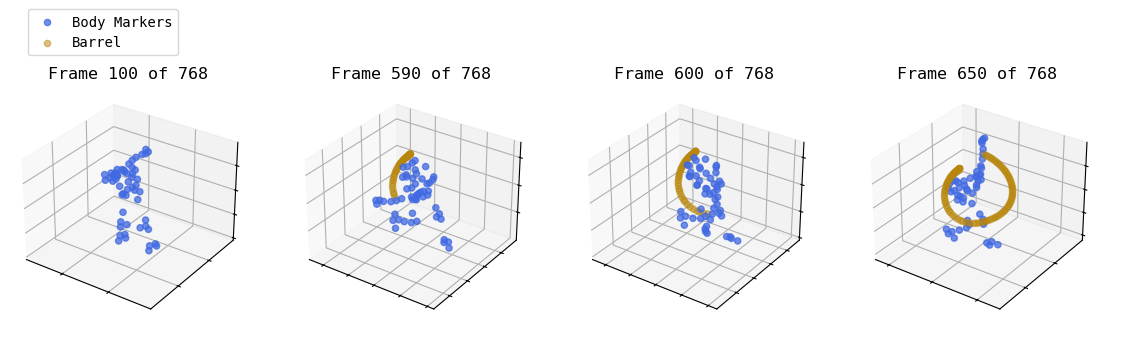

In [6]:
marker5_index = [i for i, label in enumerate(labels) if label == "Marker5"][0]

fig = plt.figure(figsize=(14, 5))
select_frames = [100, 590, 600, 650]
approx_swing_init_frame = 550
for i, frame in enumerate(select_frames):
    ax = fig.add_subplot(1, 4, i+1, projection='3d')
    x = points[0, :, frame]
    y = points[1, :, frame]
    z = points[2, :, frame]
    marker_points = ax.scatter(x, y, z, alpha=0.75, color="royalblue")
    barrel_points = ax.scatter(
        xs=points[0, marker5_index, approx_swing_init_frame:frame],
        ys=points[1, marker5_index, approx_swing_init_frame:frame],
        zs=points[2, marker5_index, approx_swing_init_frame:frame],
        color="darkgoldenrod",
        alpha=0.5
    )
    ax.set_title(f"Frame {frame} of 768")
    ax.axis('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.view_init(elev=30, azim=-55, roll=0)
    
fig.legend((marker_points, barrel_points), ("Body Markers", "Barrel"), bbox_to_anchor=(0, 0.5, 0.25, 0.4));

In addition to the 3d points, the c3d file format also supports the collection of analog contextual data. The OpenBiomechanics hitting c3d files include [force plate](approx_swing_init_frame) readings from the batter's box.

In [7]:
print(c["header"]["analogs"])

{'size': 24, 'frame_rate': 1080.0, 'first_frame': 0, 'last_frame': 2303}


Notably, this ground reaction force data is sampled at a different rate than the 3d spatial information. From the same swing, we have 2,304 total analog frames, each capturing the force and moment in the x/y/z directions for each of the 4 force plates. 

In [8]:
analog_labels = c["parameters"]["ANALOG"]["LABELS"]["value"]
analog_units = c["parameters"]["ANALOG"]["UNITS"]["value"]
print(analog_labels)

['Fx1', 'Fy1', 'Fz1', 'Mx1', 'My1', 'Mz1', 'Fx2', 'Fy2', 'Fz2', 'Mx2', 'My2', 'Mz2', 'Fx3', 'Fy3', 'Fz3', 'Mx3', 'My3', 'Mz3', 'Fx4', 'Fy4', 'Fz4', 'Mx4', 'My4', 'Mz4']


In [9]:
analog_points = c["data"]["analogs"]
print(analog_points.shape)

(1, 24, 2304)


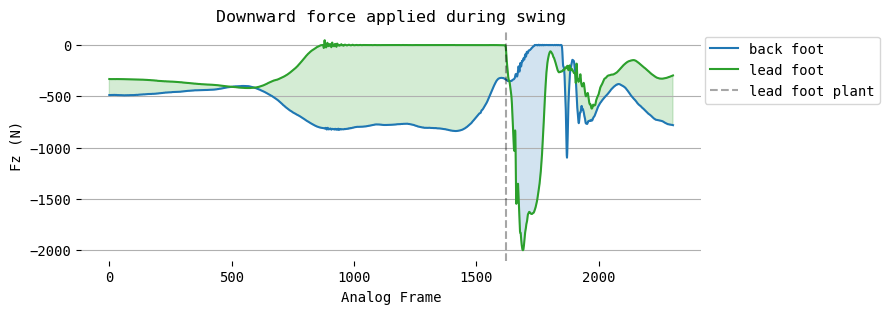

In [10]:
Fz1_index = [i for i, label in enumerate(analog_labels) if label == "Fz1"][0]
Fz4_index = [i for i, label in enumerate(analog_labels) if label == "Fz4"][0]

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
x = np.arange(analog_points.shape[2])
back_foot_force = analog_points[0, Fz4_index, :]
lead_foot_force = analog_points[0, Fz1_index, :]

ax.plot(x, back_foot_force, color="tab:blue",label="back foot")
ax.plot(x, lead_foot_force, color="tab:green", label="lead foot")
ax.fill_between(
    x,
    back_foot_force,
    lead_foot_force,
    where=back_foot_force>lead_foot_force,
    alpha=0.2,
    color="tab:blue"
)
ax.fill_between(
    x,
    back_foot_force,
    lead_foot_force,
    where=back_foot_force<=lead_foot_force,
    alpha=0.2,
    color="tab:green"
)
ax.axvline(1620, color="black", linestyle="dashed", alpha=0.35, label="lead foot plant")
ax.set_xlabel("Analog Frame")
ax.set_ylabel(f"Fz ({analog_units[Fz4_index]})")
ax.set_title("Downward force applied during swing")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.grid(axis="y")
ax.legend(bbox_to_anchor=(0, 0.5, 1.3, 0.5));